# Importing packages and reading in data

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

train_tgt = pd.read_csv("Data/Train_data_tgt.csv") 
train_tgt = train_tgt.drop(columns = ['Unnamed: 0'])
test_tgt = pd.read_csv("Data/Test_data_tgt.csv")
test_tgt = test_tgt.drop(columns = ['Unnamed: 0'])
train_sep = pd.read_csv("Data/Train_data_sep.csv")
train_sep = train_sep.drop(columns = ['Unnamed: 0'])
test_sep = pd.read_csv("Data/Test_data_sep.csv")
test_sep = test_sep.drop(columns = ['Unnamed: 0'])

# Class imbalance functions

In [6]:
def random_undersample(train_data):
    train_data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    negative_class = train_data[train_data['label'] == 0]
    positive_class = train_data[train_data['label'] == 1]
    sampled_majority_class = negative_class.sample(n=len(positive_class), random_state=45)
    output = pd.concat([sampled_majority_class, positive_class],axis = 0,ignore_index = True)
    return output

def GANsampling(train_data,no_of_samples = 50000):
    data = train_data.drop(columns = ["gene_id","Transcript_ID","Base_seq"])
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=data)
    metadata.update_column("label",sdtype="categorical")
    CTGAN = CTGANSynthesizer(
        metadata, 
        enforce_rounding=False,
        epochs=50,
        verbose=False
    )
    CTGAN.fit(data)
    CT_samples = CTGAN.sample(num_rows=no_of_samples)
    New_positive = CT_samples[CT_samples["label"] == 1]
    output = pd.concat([data,New_positive],axis = 0, ignore_index = True) 
    return output

def adasyn_sample(train):
    X = train.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"])
    y = train['label']
    adasyn_model = ADASYN(sampling_strategy='auto', random_state=42)
    X_adasyn_sample, y_adasyn_sample = adasyn_model.fit_resample(X, y)
    output = pd.concat([X_adasyn_sample, y_adasyn_sample], axis=1)
    return output

# Balanced Random Forest

### tgt

In [30]:
from imblearn.ensemble import BalancedRandomForestClassifier

X_train = train_tgt.drop(columns = ["label","gene_id", "Transcript_ID","Base_seq"], axis=1)
Y_train = train_tgt['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, Y_train)

Y_pred = brf.predict_proba(X_test)[:, 1]

C:\Users\Song Heng\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Song Heng\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


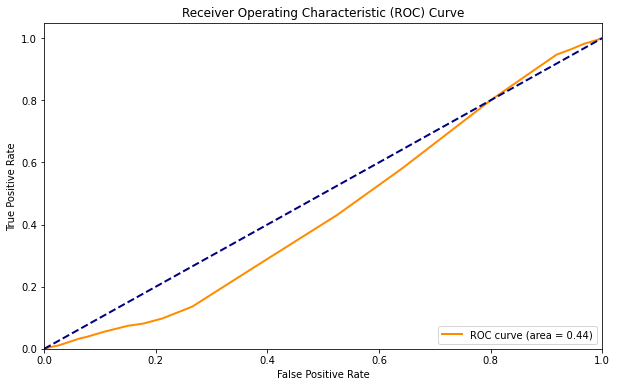

In [31]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

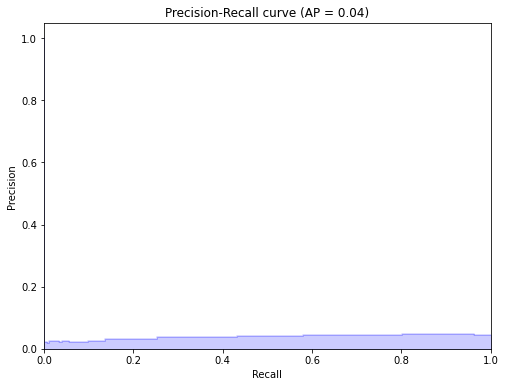

In [32]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### sep

In [33]:
X_train = train_sep.drop(columns = ["label","gene_id", "Transcript_ID","Base_seq"], axis=1)
Y_train = train_sep['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, Y_train)

Y_pred = brf.predict_proba(X_test)[:, 1]

C:\Users\Song Heng\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\Song Heng\anaconda3\lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


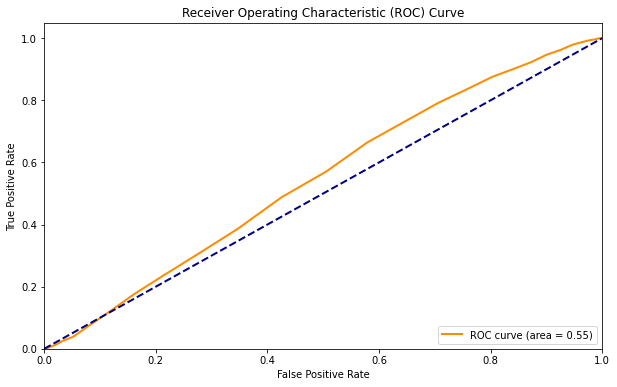

In [34]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

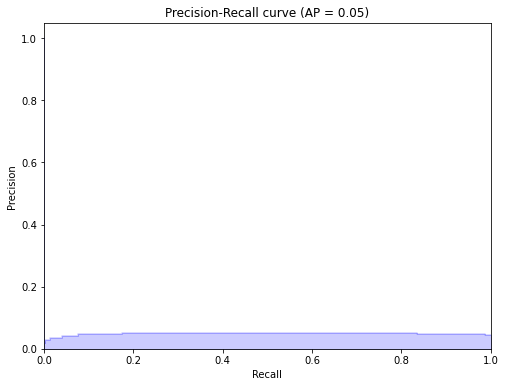

In [35]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Principal Components with mean and std together

### Random Undersample

In [19]:
new_train_data = random_undersample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [20]:
Y_pred = rf_classifier.predict_proba(X_test)[:, 1]

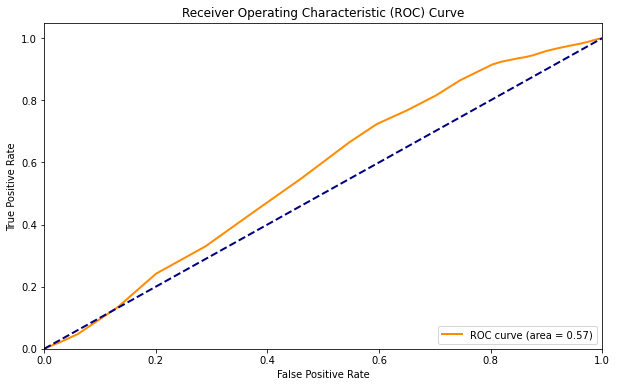

In [21]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

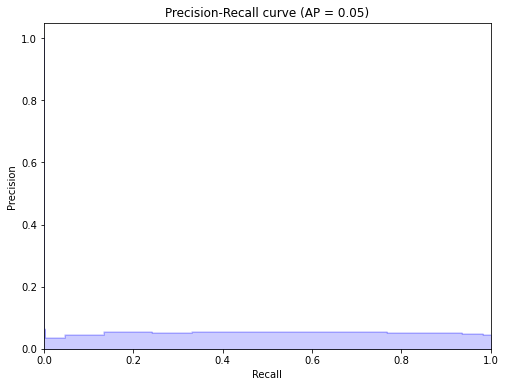

In [22]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [40]:
new_train_data = random_undersample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

Y_pred = rf_classifier.predict_proba(X_test)[:, 1]

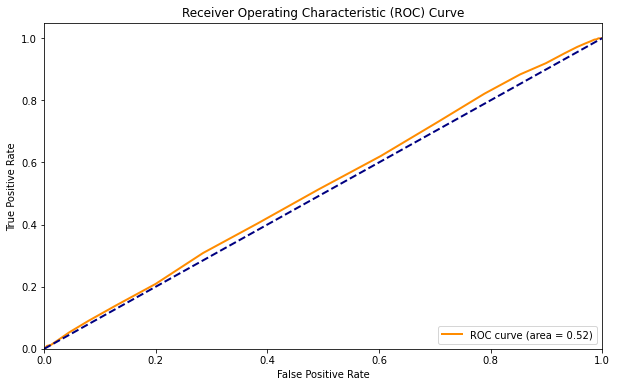

In [41]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

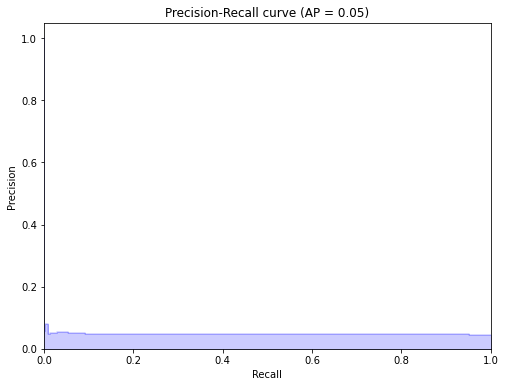

In [42]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### GAN sampling

In [23]:
new_train_data = GANsampling(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

ContextualVersionConflict: (cloudpickle 2.0.0 (c:\users\song heng\anaconda3\lib\site-packages), Requirement.parse('cloudpickle<3.0,>=2.1.0'), {'sdv'})

In [24]:
Y_pred = rf_classifier.predict_proba(X_test)[:, 1]

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### Adasyn

In [36]:
new_train_data = adasyn_sample(train_tgt)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_tgt.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_tgt['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [37]:
Y_pred = rf_classifier.predict_proba(X_test)[:, 1]

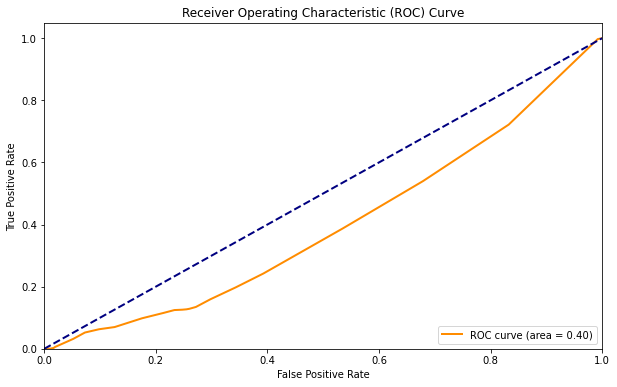

In [38]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

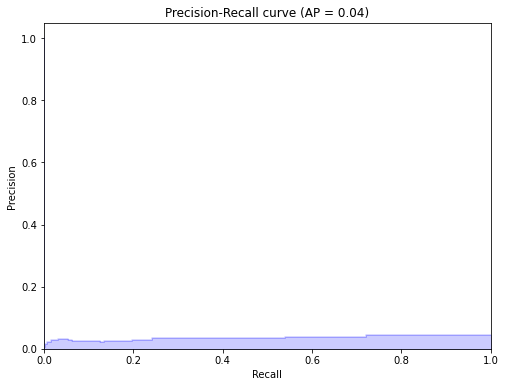

In [39]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

In [ ]:
new_train_data = adasyn_sample(train_sep)
X_train = new_train_data.drop('label', axis=1)
Y_train = new_train_data['label']
X_test = test_sep.drop(columns = ["label","gene_id","Transcript_ID","Base_seq"],axis = 1)
Y_test = test_sep['label']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, Y_train)

Y_pred = rf_classifier.predict_proba(X_test)[:, 1]

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
#accuracy = accuracy_score(Y_test, Y_pred)
#print(f'Accuracy: {accuracy * 100:.2f}%')
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
#plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)

# Calculate the average precision score
average_precision = average_precision_score(Y_test, Y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()